In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import shap
import xgboost as xgb
from sklearn.metrics import auc, roc_curve

from scripts.utils import objective_xgboost, bootstrap_test, create_balanced_cv

optuna.logging.set_verbosity(optuna.logging.WARNING)

/home/aubouinb/Téléchargements/hypotension_pred-main/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
SIGNAL_FEATURE = ['mbp', 'sbp', 'dbp', 'hr', 'rr', 'spo2', 'etco2', 'mac', 'pp_ct']
STATIC_FEATURE = ["age", "bmi", "asa", "preop_cr", "preop_htn"]
HALF_TIME_FILTERING = [10, 60, 60*5]

FEATURE_NAME = (
    [
        f"{signal}_ema_{half_time}"
        for signal in SIGNAL_FEATURE
        for half_time in HALF_TIME_FILTERING
    ]
    + [
        f"{signal}_std_{half_time}"
        for signal in SIGNAL_FEATURE
        for half_time in HALF_TIME_FILTERING
    ]
    + STATIC_FEATURE
)

BASELINE_FEATURE_NAME = 'mbp_ema_10'

## Load and format data

In [3]:
# import the data frame and add the meta data to the segments
data = pd.read_parquet(Path('data/datasets/base_dataset_no_leading_time/cases/'))

static = pd.read_parquet('data/datasets/base_dataset_no_leading_time/meta.parquet')

data = data.merge(static, on='caseid')

data.asa = data.asa.astype(int)
data.preop_htn = data.preop_htn.astype(int)



## Train or load existing model


In [4]:
# control reproducibility
rng_seed = 42

result_folder = Path("data/results")
if not result_folder.exists():
    result_folder.exists()

for leading_time in range(0,7,2):
    data_lead = data[(data.time_before_IOH >= leading_time*60) | (data.time_before_IOH.isna())]

    train = data_lead[data_lead['split'] == "train"]
    test = data_lead[data_lead['split'] == "test"]

    train_case_label = train.groupby("caseid").agg(
                segment_count=("label", "count"),
                label_count=("label", "sum"),
            )

    train_cv_split = create_balanced_cv(train_case_label, nb_max_iter=100000)


    
    train = train.dropna(subset=FEATURE_NAME)
    test = test.dropna(subset=FEATURE_NAME)
    print('leading time:', leading_time)
    print(
        f'{len(train)} train samples and {len(test)} test samples, positive rate = {test["label"].mean():.2f}'
    )

    # Set model file, create models folder if does not exist.
    model_folder = Path("data/models")
    if not model_folder.exists():
        model_folder.mkdir()
    model_file = model_folder / f"xgb_lead_{leading_time}.json"

    # create a regressor
    if model_file.exists():
        model = xgb.XGBClassifier()
        model.load_model(model_file)
    else:
        # creat an optuna study
        study = optuna.create_study(direction="maximize")
        study.optimize(
            lambda trial: objective_xgboost(trial, train, FEATURE_NAME, train_cv_split),
            n_trials=80,
            show_progress_bar=True,
        )

        # get the best hyperparameters
        best_params = study.best_params

        model = xgb.XGBClassifier(**best_params)
        # refit the model with best parameters
        model.fit(train[FEATURE_NAME], train.label, verbose=1)

        # save the model
        model.save_model(model_file)

    # test the model
    y_pred = model.predict_proba(test[FEATURE_NAME])[:, 1]
    y_test = test["label"].values
    y_label_id = test["label_id"].values

    df_results, _ = bootstrap_test(y_test, y_pred, y_label_id, n_bootstraps=200, rng_seed=rng_seed)
    
    roc_results = result_folder / f"xgboost_roc_lead_{leading_time}.csv"
    df_results.to_csv(roc_results, index=False)

    #test baseline
    y_pred_baseline = 1 - test[BASELINE_FEATURE_NAME].values/120

    df_results_baseline, _ = bootstrap_test(y_test, y_pred_baseline, y_label_id, n_bootstraps=200, rng_seed=rng_seed)

    roc_results = result_folder / f"baseline_roc_lead_{leading_time}.csv"
    df_results_baseline.to_csv(roc_results, index=False)



split 0 : 35265 segments, 2403 labels, 0.06814121650361549 ratio label
split 1 : 34690 segments, 2788 labels, 0.08036898241568176 ratio label
split 2 : 35798 segments, 2043 labels, 0.05707022738700486 ratio label
leading time: 0
105753 train samples and 40545 test samples, positive rate = 0.07
split 0 : 33236 segments, 1970 labels, 0.05927307738596702 ratio label
split 1 : 34083 segments, 2031 labels, 0.05958982483936273 ratio label
split 2 : 36823 segments, 1622 labels, 0.04404855660864134 ratio label
leading time: 2
104142 train samples and 39882 test samples, positive rate = 0.06


Best trial: 61. Best value: 0.7289: 100%|██████████| 80/80 [11:42<00:00,  8.78s/it]  


split 0 : 33857 segments, 1446 labels, 0.04270904096641758 ratio label
split 1 : 34858 segments, 1402 labels, 0.04022032245108727 ratio label
split 2 : 33903 segments, 1251 labels, 0.036899389434563314 ratio label
leading time: 4
102618 train samples and 39257 test samples, positive rate = 0.04


Best trial: 65. Best value: 0.692323: 100%|██████████| 80/80 [13:56<00:00, 10.46s/it]


split 0 : 35014 segments, 904 labels, 0.02581824413091906 ratio label
split 1 : 33191 segments, 910 labels, 0.02741707089271188 ratio label
split 2 : 32972 segments, 844 labels, 0.025597476646851875 ratio label
leading time: 6
101177 train samples and 38704 test samples, positive rate = 0.03


Best trial: 31. Best value: 0.687738: 100%|██████████| 80/80 [09:51<00:00,  7.39s/it]


## Plot

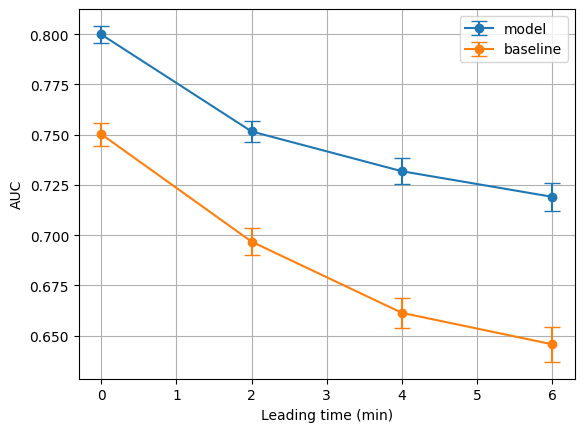

In [7]:
xgboost_auc_list, baseline_auc_list, lead_time_list = [], [], []
xgboost_auc_std_list, baseline_auc_std_list = [], []

for leading_time in range(0,7,2):
    lead_time_list.append(leading_time)
    roc_results = result_folder / f"xgboost_roc_lead_{leading_time}.csv"
    df_results = pd.read_csv(roc_results)
    xgboost_auc_list.append(df_results.auc[0])
    xgboost_auc_std_list.append(df_results.auc_std[0])

    roc_results = result_folder / f"baseline_roc_lead_{leading_time}.csv"
    df_results = pd.read_csv(roc_results)
    baseline_auc_list.append(df_results.auc[0])
    baseline_auc_std_list.append(df_results.auc_std[0])
    

plt.errorbar(lead_time_list, xgboost_auc_list,xgboost_auc_std_list, fmt='-o', label='model', capsize=6)
plt.errorbar(lead_time_list, baseline_auc_list, baseline_auc_std_list, fmt='-o', label='baseline', capsize=6)
plt.xlabel('Leading time (min)')
plt.ylabel('AUC')
plt.grid()
plt.legend()
plt.show()

#save the data
auc_df = pd.DataFrame({'lead_time': lead_time_list, 'xgboost_auc': xgboost_auc_list, 'xgboost_auc_std': xgboost_auc_std_list, 'baseline_auc': baseline_auc_list, 'baseline_auc_std': baseline_auc_std_list})
auc_df.to_csv(result_folder / 'auc_lead_time.csv', index=False)

In [6]:
xgboost_auc_std_list

[0.0042664390396356,
 0.0052190363167045,
 0.0063728506939346,
 0.0070242946503213]